# 房价预测


## 分析目的 

通过描述爱荷华州埃姆斯（Ames）地区房屋的79个特征，预测房价。

## 数据集介绍


- 数据集来源：[Kaggle 公开数据集](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)
- 目标特征：SalePrice 销售房价（美元）


## 代码实现

### 导入相关库

In [ ]:
import numpy as np  # 科学计算工具包
import pandas as pd  # 数据分析工具包
import matplotlib.pyplot as plt # 图表绘制工具包
import seaborn as sns # 基于 matplot, 导入 seaborn 会修改默认的 matplotlib 配色方案和绘图样式，这会提高图表的可读性和美观性
import os
from scipy import stats
from scipy.stats import norm, skew 

plt.rc("font",family="SimHei",size="15")  #解决中文乱码问题

# 在 jupyter notebook 里面显示图表
%matplotlib inline 

### 获取数据集


In [ ]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

df_train.head()

In [ ]:
# 所有字段列表

df_train.columns

根据常识，我们猜测房价和

- 房屋整体质量(OverallQual)
- 建立年份(YearBuilt)
- 地下室面积(TotalBsmtSF)
- 地上居住面积(GrLivArea)

四个特征有关。


### 数据探索（EDA）

我的目的是预测房价(美元)，先看看训练集中的房价

In [ ]:
# 描述性统计数据

df_train['SalePrice'].describe()

In [ ]:
# 房价直方图

plt.figure(figsize=(16, 5))
#去掉拟合的密度估计曲线，kde参数设为False
sns.distplot(df_train['SalePrice'],kde=False)  
# 'kde' 是控制密度估计曲线的参数，默认为 True，不设置会默认显示，如果我们将其设为 False，则不显示密度曲线。

可以看出大部分房价位于10-20万美元之间，分布呈右偏。这就意味着我们之后要对目标值做一些处理，因为回归模型在正态分布的数据集上表现更好。

##### **知识点：数据偏度和峰度**

- 偏度是衡量随机变量概率分布的不对称性，是相对于平均值不对称程度的度量，通过对偏度系数的测量，我们能够判定数据分布的不对称程度以及方向。
    + 偏度大于0表示其数据分布形态与正太分布相比为正偏或右偏；有一条长尾巴在右边；
    + 反之左偏，即有一条长尾巴在左边

- 峰度是研究数据分布陡峭或平滑的统计量，通过对峰度系数的测量，我们能够判定数据相对于正态分布而言是更陡峭/平缓。
    - 这个统计量需要与正态分布相比较，
        + 峰度为0表示该总体数据分布与正态分布的陡缓程度相同；
        + 峰度大于0表示该总体数据分布与正态分布相比较为陡峭，为尖顶峰；
        + 峰度小于0表示该总体数据分布与正态分布相比较为平坦，为平顶峰。
    - 峰度的绝对值数值越大表示其分布形态的陡缓程度与正态分布的差异程度越大。
    
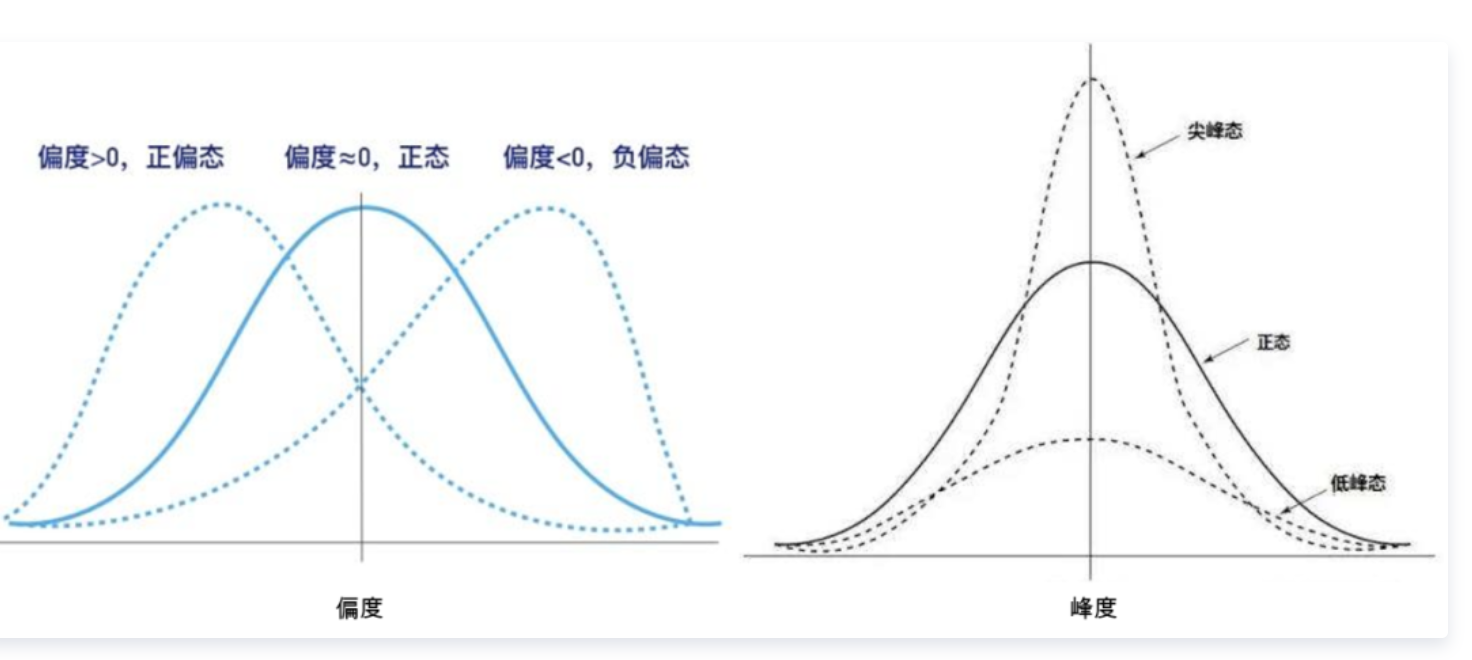

In [ ]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

#### 地上居住面积 Grlivarea 与 房价 SalePrice 特征间的散点图

In [ ]:
#  Grlivarea 与 SalePrice 

plt.figure(figsize=(16, 8))
plt.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.ylim=(0,800000)  # y坐标轴范围
plt.xlabel('Grlivarea ')  # x轴名称
plt.ylabel('SalePrice ')  # y轴名称
plt.title(' Grlivarea and SalePrice') #标题

GrLivAre 指的是地面以上的居住面积，包括卧室、厨房、客厅等，但不包括地下室和房子外的走廊过道等。

正常来说，更大的居住面积意味着更高的价格。这张图基本印证了这点。两者之间基本呈正相关性。

但图中显示，有2个拥有较大居住面积的房屋价格却很低。

#### 地下室面积 TotalBsmtSF 与 房价 SalePrice 特征间的散点图

In [ ]:
#  TotalBsmtSF 与 SalePrice 

plt.figure(figsize=(16, 8))
plt.scatter(x=df_train['TotalBsmtSF'], y=df_train['SalePrice'])
plt.ylim=(0,800000)  # y坐标轴范围
plt.xlabel('TotalBsmtSF ')  # x轴名称
plt.ylabel('SalePrice ')  # y轴名称
plt.title('TotalBsmtSF and SalePrice') #标题

####  房屋整体质量 OverallQual 与 房价 SalePrice 特征的箱型图

In [ ]:
#  OverallQual 与 SalePrice 

plt.figure(figsize=(16, 8))
sns.boxplot(x=df_train['OverallQual'], y=df_train['SalePrice'])
plt.ylim=(0,800000)  # y坐标轴范围
plt.xlabel('OverallQual')  # x轴名称
plt.ylabel('SalePrice ')  # y轴名称
plt.title('OverallQual and SalePrice') #标题

OverallQual 房屋整体质量指的是房屋的整体建材质量和品质。OverallQual值越高，价格自然也更贵。

因此，从散点图可以看到，OverallQual 房屋整体质量和 SalePrice 房价呈现正相关性。

####  建立年份 YearBuilt 与 房价 SalePrice 特征的箱型图

In [ ]:
#  YearBuilt 与 SalePrice 

plt.figure(figsize=(16, 8))
sns.boxplot(x=df_train['YearBuilt'], y=df_train['SalePrice'])
plt.ylim=(0,800000)  # y坐标轴范围
plt.xticks(rotation=90) # x轴标签旋转90度
plt.xlabel('Yearbuilt')  # x轴名称
plt.ylabel('SalePrice')  # y轴名称
plt.title(' YearBuilt and SalePrice') #标题

两者之间没有很强的关系，但一般而言，新房相比老房的价格更高，因为新房相比老房也有很大的好处，比如更保暖、装有中央空调、房型设计更合理等。

到现在为止，我们只是遵循我们的直觉，分析了我们认为重要的变量。尽管我们努力为我们的分析提供客观性，但我们必须说，我们的出发点是主观的。接下来，做一个更客观的分析。

#### 相关性分析

##### 所有特征的相关性分析

In [ ]:
#将生成的相关系数矩阵以热力图的形式展现出来
#这个corr是计算DataFrame中列之间的相关系数，如果存在非数值类型，则会自动排除

corrmat = df_train.corr()#相关系数，比如有n列，则相关系数矩阵大小为n*n，其中的(i,j)表示的是第i列和第j列之间的相关系数，最后生成的是DataFrame
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);#vmax=.8表示设置最大值为0.8；square表示将Axes横纵比设置为相等，这样每个单元格都是正方形

可以看到对角线有一条白线，这代表相同特征的相关性为最高，但值得注意的是，有两个正方形小块：TotaLBsmtSF 和 1stFlrSF、GarageArea 和 GarageCars 处。这代表地下室面积 TotaLBsmtSF 与一层建筑面积 1stFlrSF 成强正相关，车库面积 GarageArea 和车库车辆容量大小 GarageCar 成强正相关。


##### 与目标特征相关性最高的十个特征

由于特征比较多，我们可以取与目标特征相关性最高的十个特征再次绘制相关度热图：

In [ ]:
#分析与目标特征房价 SalePrice 相关度最高的十个变量

k = 10
#corrmat.nlargest表示的是在SalePrice列中选出最大的前k个对应的行，也就是说这样做之后的效果是生成了10*38的DataFrame
cols_10 = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
corrs_10 = df_train[cols_10].corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corrs_10, annot=True) # annot: 如果为true，数据写到每个单元上

从图中可以看出：

 - OverallQual 房屋整体质量，GrLivArea 地上居住面积以及 TotalBsmtSF 地下室面积与 SalePrice 有很强的相关性。
- 车库面积 GarageArea 和车库车辆容量大小 GarageCar 之间相关性较强. 车库车辆容量大小 GarageCar 是由车库面积 GarageArea 决定的，所以不需要专门区分 GarageCars 和 GarageAre，所以我们只需要其中的一个变量。这里我们选择了 GarageCars，因为它与 SalePrice 的相关性更高一些。
- 地下室面积 TotaLBsmtSF 与一层建筑面积 1stFlrSF 与上述情况相同，我们选择 TotalBsmtS 。
- FullBath 是针对 halfbath room的，full bathroom 是带淋浴的，而 half bathroom 只有洗手盆、马桶，两者的区别就是能否洗澡。
- TotRmsAbvGrd 地上房间数(不包括浴室)和 GrLivArea 地上居住面积成正相关，选择 GrLivArea。
- YearBuilt 建立年份和 SalePrice 房价相关性似乎不强。


##### 绘制筛选后特征之间的散点图

In [ ]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)
plt.show()

可以看到对角线上是各个特征的直方图(分布图)，而非对角线上是两个不同特征之间的散点图，从图中可以看出，我们已经发现的特征间关系。

其中，TotalBsmtSF(y轴) 和 GrLiveArea(x轴) 之间的散点图是很有意思的。我们可以看出这幅图中，一些点组成了线，就像边界一样。大部分点都分布在那条线下面，这也是可以解释的。但是大部分情况，地上居住面积都大于等于地下室面积。
 
SalePrice(y轴) 和 YearBuilt(x轴)之间的散点图也值得我们思考。在 “点云” 的底部，我们可以观察到一个几乎呈指数函数的分布。我们也可以看到 “点云” 的上端也基本呈同样的分布趋势。并且可以注意到，近几年的点有超过这个上端的趋势。


### 数据预处理

由于 id 特征对于预测模型没有任何帮助，因此把id 特征删除

In [ ]:
# 把“Id”这一列从数据集中单独挑出，便于操作

#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(df_train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(df_test.shape))


#### 异常值

In [ ]:
#  Grlivarea 与 SalePrice 

plt.figure(figsize=(16, 8))
plt.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.ylim=(0,800000)  # y坐标轴范围
plt.xlabel('Grlivarea')  # x轴名称
plt.ylabel('SalePrice')  # y轴名称
plt.title('Grlivarea and SalePrice') #标题

- 从图中可以明显的看出：有两个具有巨大面积的房屋的房价显然过低，因此可以安全地删除它们。
- 注意：虽然训练数据中还有其他的异常值可以删除，但无法保证测试数据集中也有异常值，若删除训练样本中的大量异常值会影响测试集上的精度。因此只删除了两个，以使模型更健壮。

In [ ]:
# 删除这两个离群值
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

# 重绘图以查看是否剔除异常值
plt.figure(figsize=(16, 8))
plt.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.ylim=(0,800000)  # y坐标轴范围
plt.xlabel('Grlivarea')  # x轴名称
plt.ylabel('SalePrice')  # y轴名称
plt.title(' Grlivarea and SalePrice ') #标题

#### 目标特征

房价（SalePrice）是我们需要预测的目标特征。在数据探索的时候，我们发现目标值是右偏斜的，所以对目标值取对数，将其处理成近似正态分布，查看目标特征的分布。

displot()集合了matplotlib的hist()与核函数估计kdeplot的功能，增加了rugplot分布观测条显示与利用scipy库fit拟合参数分布的新颖用途。具体用法如下：

```
seaborn.distplot(a, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
```

- fit：控制拟合的参数分布图形，能够直观地评估它与观察数据的对应关系(黑色线条为确定的分布)

In [ ]:
# 绘制目标特征的概率分布图
plt.figure(figsize=(16, 8))
sns.distplot(df_train['SalePrice'], fit=norm) # 拟合标准正态分布
plt.legend(['Normal dist'], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# 获取目标特征的正态分布参数
(mu, sigma) = norm.fit(df_train['SalePrice']) # fit方法：对一组随机取样进行拟合，最大似然估计方法找出最适合取样数据的概率密度函数系数。
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

`scipy.stats.probplot(x, sparams=(), dist='norm', fit=True, plot=None, rvalue=False)`

计算概率图的分位数，生成样本数据相对于指定理论分布(默认为正态分布)的分位数的概率图。probplot(可选)为数据计算一条best-fit线，并使用Matplotlib或给定的绘图函数对结果进行绘图。


##### 知识点：QQ图

如何检验样本是否服从正态分布？

分位数图示法（Quantile Quantile Plot，简称 Q-Q 图）

统计学里Q-Q图（Q代表分位数）是一个概率图，用图形的方式比较两个概率分布，把他们的两个分位数放在一起比较。首先选好分位数间隔。图上的点（x,y）反映出其中一个第二个分布（y坐标）的分位数和与之对应的第一分布（x坐标）的相同分位数。因此，这条线是一条以分位数间隔为参数的曲线。如果两个分布相似，则该Q-Q图趋近于落在y=x线上。如果两分布线性相关，则点在Q-Q图上趋近于落在一条直线上，但不一定在y=x线上。Q-Q图可以用来可在分布的位置-尺度范畴上可视化的评估参数。

从定义中可以看出Q-Q图主要用于检验数据分布的相似性，如果要利用Q-Q图来对数据进行正态分布的检验，则可以令x轴为正态分布的分位数，y轴为样本分位数，如果这两者构成的点分布在一条直线上，就证明样本数据与正态分布存在线性相关性，即服从正态分布。

In [ ]:
# 绘制QQ-plot图

plt.figure(figsize=(16, 8))
res = stats.probplot(df_train['SalePrice'], plot=plt)

图中可见目标变量呈现一种偏态分布，需要将其转换为正态分布以便运用线性回归模型。


构建模型时为什么要尽量将偏态数据转换为正态分布数据？

很多算法，例如线性回归，它的推导是基于一个基本的假设-数据服从高斯分布(正态分布),如果数据不服从高斯分布,那么线性回归的推导根本就是空谈。不幸的是，现实中很少有数据完美的服从高斯分布，我们获取到的数据并不是呈现标准的正态分布,

这就需要我们做一下转换。


##### 对数变换

明显右偏，取对数。这里运用了log1p函数，返回的是 log(1+x)。

In [ ]:
# 正态化Y
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

# 绘制分布图检查新的分布
sns.distplot(df_train['SalePrice'], fit=norm);
plt.legend(['Normal dist'], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# 获取新的正态分布参数
(mu, sigma) = norm.fit(df_train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# 绘制QQ-plot图
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

可以看出，转化后，目标特征已经接近正态分布了。

### 特征工程

#### 缺失值

因为训练集和测试集都需要处理缺失值，这里先将训练集和测试集合并起来，再把目标特征 SalePrice 删除。

In [ ]:
ntrain = df_train.shape[0] # 训练集数目
ntest = df_test.shape[0] # 测试集数目
y_train = df_train.SalePrice.values # 训练集的Y
all_data = pd.concat((df_train, df_test)).reset_index(drop=True) # 删除目标特征 SalePrice
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

In [ ]:
# 统计缺失值数量和占比

def missing_info(data,num):
    # func:统计缺失值数量和占比函数
    # data: dataframe类型
    # num: 数字类型，显示前几行数据
    # return: 缺失值统计\占比

    null_data = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()
    missing_data = pd.concat([null_data,percent_1.apply(lambda x: format(x, '.2%'))],axis=1,keys=['total missing','missing percentage'])
    return missing_data.head(num)

missing_data = missing_info(all_data,40) 
missing_data

##### 缺失值处理方法一

PoolQC, MiscFeature, Alley, Fence, FireplaceQu：这些特征里的空值代表样本房屋不包含泳池、篱笆等设施，因此用None来填充。

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrontage：房屋与街道之间的直线距离（英尺），可以用同一个地区其他样本该项的中位数来补全。Neighborhood 是指房屋的地理位置。

##### 知识点：transform 用法

In [ ]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

GarageType, GarageFinish, GarageQual, GarageCond 车库相关特征是类别型数据，用None来填充，缺失表示没有车库。

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

GarageYrBlt, GarageArea, GarageCars 车库相关特征是数值型数据，用0来填充，没有车库，这些数值型数据都是0。

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2：地下室相关特征为类别型，用None来填充，缺失表示没有地下室。

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath：地下室相关特征为数值型，用0来填充，没有地下室，这些数值型数据都是0。

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

MasVnrArea, MasVnrType：缺失值值代表样本房屋不包含砖石贴面墙，因此分别用0和None来填充。

In [ ]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

MSZoning, Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType：因为这些变量中仅有个别缺失值，可采用众数填充。

In [ ]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

Utilities：这一项大部分都是 AllPub，除了1个 NoSeWa 和 2个缺失值。该特征在训练集中有1个是 NoSeWa，而在测试集中都是 AllPub，也就是说这一个特征对预测模型没有任何影响，故删去。

In [ ]:
all_data = all_data.drop(['Utilities'], axis=1)

In [ ]:
print(df_train['Utilities'].unique())
print(df_test['Utilities'].unique())

Functional：空值代表Typ（典型）。

In [ ]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

MSSubClass：缺失值可能意味着该样本的房屋没有建筑等级，用None来填充。

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

然后再检查一遍是否还遗漏了未补全的缺失值。

In [ ]:
# 再次检查缺失值
missing_data = missing_info(all_data,5) 
missing_data

#### 转换类别特征

##### 数值型转换为类别型

诸如 MSSubClass（住宅类型）、OverallCond（房屋总体条件）等特征，虽然它们的值是数字，但本质上属于类别型，需将其转化为字符串类型。

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

##### 有序型转换为数值型

诸如 FireplaceQu（壁炉质量）、BsmtQual（地下室高度）、GarageQual（车库质量）等特征，虽然它们是类别型特征，但其隐含了顺序/等级的意义（如质量的好坏、功能的多少）。

类别特征不能直接输入模型，因此要对其进行编码，把它转换成数字。编码有两种方式，对于各个类别中可能存在顺序关系的，用 LabelEncoder编码，对于不存在顺序关系的，用 One-Hot-Encoder 编码（在pandas中有现成的独热编码方法 pd.get_dummies()方法）。

先处理存在顺序关系的这部分特征：

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() # 创建 labelencoder 实例
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values)) 

OverallQual、MSZoning、LandContour、Utilities、LotConfig、Neighborhood、Condition1、Condition2、BldgType、HouseStyle、RoofStyle、RoofMatl、Exterior1st、Exterior2nd、MasVnrType、Foundation、Heating、Electrical: Electrical system、GarageType、MiscFeature: Miscellaneous feature not covered in other categories、SaleType: Type of sale、SaleCondition: Condition of sale

还有以上这些类别特征没有处理

##### 知识点：编码

在开始建模之前，我们要执行的最后一步是将我们所有的分类特征转换为数字，因为我们的算法只能接受一个数字数组作为输入，而不是名字或字母。我们有几个列要转换。

为什么要进行特征编码？

我们拿到的数据通常比较脏乱，可能会带有各种非数字特殊符号，比如中文。下面这个表中显示了我们最原始的数据集。而实际上机器学习模型需要的数据是数字型的，因为只有数字类型才能进行计算。因此，对于各种特殊的特征值，我们都需要对其进行相应的编码，也是量化的过程。

对于分类型数据的编码，我们通常会使用两种方式来实现，分别是：one-hot encoding 和 label-encoding。

在pandas中有现成的独热编码方法 pd.get_dummies()方法，将分类特征转换为数字特征。


Label-Encoding, (独热编码)One-Hot-Encoder 编码区别
[Categorical encoding using Label-Encoding and One-Hot-Encoder](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)

[机器学习“特征编码”](https://zhuanlan.zhihu.com/p/42075740)


#### 创造新特征

鉴于房屋面积在决定房价的各个特征中居于主导地位，添加了一个新的特征 TotalSF，它是房屋地下室、第一层和第二层面积的总和。

In [ ]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [ ]:
all_data.info()

#### 处理偏斜特征

##### 知识点：正态化：box-cox变换

当数据不满足正态分布时，教科书里常常说可以通过变量变换将原始数据做某种函数的转换，常用的变量变换有对数变换、平方根变换、平方根反正弦变换、倒数变换等，这些变换有各自适用的数据，需要多次尝试来寻找合适的变换。适当的变换可同时满足正态化和方差齐性的要求。但对像我这种数学不好的人，选择用哪种变换的确是一件挺难的事。

实际中常用Box-Cox变换，Box-Cox变换是多种变换的统称。


Boxcox变换：一种广义幂变换方法，是统计建模中常用的一种数据变换，用于连续的响应变量不满足正态分布的情况。【针对数值型特征】

In [ ]:
# 筛选出所有数值型的特征
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 检查所有数值型特征的偏态
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

由于数据中可能存在许多没有处理的异常值，为了增强模型对异常值的刚度，我们采用Box Cox转换来处理偏斜数据：

使用box-cox变换来正态化呈现明显偏态的特征

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

#### 处理其余的类别特征

把所有类别特征变成one-hot形式的特征。这一步可能会导致数据的特征数量大大增加。

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

#### 保存处理后的训练数据和测试数据

数据处理的代码和模型预测的代码最好是分成两个文件，保存处理后的数据，这样处理后的数据可以随时读入模型中进行预测，不用每次测试新的模型的时候都把前面数据处理的代码重新跑一遍。

把连接起来的所有数据再拆分回训练集和测试集：

In [ ]:
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

### 训练模型与测试



In [ ]:
# 导入库

from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC #线性回归模型
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor #集成模型
from sklearn.kernel_ridge import KernelRidge #核岭回归
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler #标准化
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #自定义类的API
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error #均方误差
import xgboost as xgb #XGBoost
# import lightgbm as lgb #lightGBM

#### 交叉验证

模型的验证有两种方法：留出法和交叉验证。因为训练集的数据较少，所以采用十折交叉验证。交叉验证使我们能够比较不同的机器学习方法。


- 直接使用cross_val_score的参数cv=5没有将数据的顺序随机打乱，因此用了KFold方法，手动添加了shuffle=True，再用get_n_splits返回K折的折数。
- random_state为随机种子，保证每次得到的结果与原作者相同，该参数可以不加。
- 返回的rmse是模型在训练集上的均方根误差。由于目标特征已经对数转换过，因此实际上该值代表的是均方根误差的对数，即RMSLE。

均方差（标准差）是数据序列与均值的关系，而均方根误差是数据序列与真实值之间的关系。因此，标准差是用来衡量一组数自身的离散程度，而均方根误差是用来衡量观测值同真值之间的偏差，它们的研究对象和研究目的不同，但是计算过程类似。

In [ ]:
# 5折交叉验证
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### 基础模型

这里选择回归问题常用的六个模型：

- LASSO Regression：该算法对异常值敏感，本例使用了Robustscaler这一标准化方法来缩放异常值。
- Elastic Net Regression 弹性网络回归
- Kernel Ridge Regression 核岭回归
- Gradient Boosting Regression：采用了Huber loss，处理异常值时更加健壮。
- XGBoost
- LightGBM

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#### 模型评估

用RMSLE评估各个基础模型在交叉验证集上的得分。

In [ ]:
models_name = ['Lasso', 'ElasticNet', 'Ridge']
models = [lasso, ENet, KRR]
for i, model in enumerate(models):
    score = rmsle_cv(model)
    print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))

In [ ]:
KRR.fit(df_train.values, y_train)
KRR_pred= np.expm1(KRR.predict(df_test.values))

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = KRR_pred
sub.to_csv('submission.csv',index=False)